# Задание
Разобраться с моделькой перевода с **Attention** как она устроена (внимание классическое с RNN-ками в энкодере и декодере), запустить для перевода с русского на английский.

-------------------------

In [1]:
import numpy as np
import unicodedata
import re
import os
from pathlib import Path
import io
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

*****************************************

# LOAD Data. Preprocessing

In [4]:
# !wget http://www.manythings.org/anki/rus-eng.zip # http://www.manythings.org/anki/ - other languages
# !mkdir rus-eng
# !unzip rus-eng.zip -d rus-eng/

In [5]:
path_to_file = os.path.join(Path(os.getcwd()), "rus-eng", "rus.txt")

In [6]:
def preprocess_sentence(w):
    w = w.lower().strip()
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
preprocess_sentence("I can't go!!!")

"<start> i can't go ! ! ! <end>"

In [8]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[
        :2]] for l in lines[:num_examples]]

    return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[-2])
print('*'*100)
print(ru[-2])

<start> it's so easy to write good example sentences , that even if we accidentally delete a few good sentences in the process of getting rid of a whole lot of bad ones , i think we could drastically improve the quality of this corpus by doing a lot of deleting . <end>
****************************************************************************************************
<start> создавать хорошие предложения примеры так легко , что даже если мы случайно удалим несколько хороших предложений в процессе избавления от кучи плохих , думаю , мы могли бы заметно улучшить качество этого корпуса , удаляя в больших количествах . <end>


In [10]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
len(en), len(ru)

(431097, 431097)

In [13]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(f" max_length of the target tensors: eng-{max_length_targ}, ru-{max_length_inp}")

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

 max_length of the target tensors: eng-11, ru-15


In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
83 ----> можно
423 ----> тот
669 ----> посмотреть
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
26 ----> can
4 ----> i
76 ----> see
17 ----> that
56 ----> one
6 ----> ?
2 ----> <end>


******

# Create a tf.data dataset. Model build

In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

## ENCODER

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


# Attantion

In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


## DECODER

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7260)


In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# TRAIN

In [25]:
checkpoint_dir = 'training_att_checkpoints'

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [27]:
EPOCHS = 20
verbose = 1
min_loss = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if (batch % 200 == 0) and (verbose == 2):
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if ((epoch + 1) % 5 == 0) and (total_loss/steps_per_epoch < min_loss):
        min_loss = total_loss / steps_per_epoch
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_", str(epoch))
        checkpoint.save(file_prefix=checkpoint_prefix)

    if verbose == 1:
        print('Epoch {} Loss {:.4f} ----> Time taken per epoch {:.1f}'.format(epoch+1,
              total_loss/steps_per_epoch, (time.time()-start)))

Epoch 1 Loss 1.4654 ----> Time taken per epoch 268.0
Epoch 2 Loss 0.6361 ----> Time taken per epoch 253.5
Epoch 3 Loss 0.3352 ----> Time taken per epoch 259.7
Epoch 4 Loss 0.2069 ----> Time taken per epoch 259.1
Epoch 5 Loss 0.1481 ----> Time taken per epoch 257.3
Epoch 6 Loss 0.1163 ----> Time taken per epoch 248.8
Epoch 7 Loss 0.0985 ----> Time taken per epoch 257.2
Epoch 8 Loss 0.0888 ----> Time taken per epoch 255.2
Epoch 9 Loss 0.0821 ----> Time taken per epoch 247.9
Epoch 10 Loss 0.0764 ----> Time taken per epoch 260.2
Epoch 11 Loss 0.0726 ----> Time taken per epoch 263.2
Epoch 12 Loss 0.0696 ----> Time taken per epoch 267.9
Epoch 13 Loss 0.0667 ----> Time taken per epoch 270.9
Epoch 14 Loss 0.0646 ----> Time taken per epoch 254.4
Epoch 15 Loss 0.0620 ----> Time taken per epoch 249.6
Epoch 16 Loss 0.0596 ----> Time taken per epoch 246.0
Epoch 17 Loss 0.0591 ----> Time taken per epoch 246.1
Epoch 18 Loss 0.0578 ----> Time taken per epoch 245.8
Epoch 19 Loss 0.0560 ----> Time taken

In [28]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [29]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(False)
    plt.show()

In [30]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(
        result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# TEST Translation

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [36]:
test_text_list = ['Вы не опоздали?',
                  'Приведите вашу жену',
                  'Позвоните мне в половине третьего',
                  'Я рассчитываю на вашу помощь'
]

Input: <start> вы не опоздали ? <end>
Predicted translation: aren't you late ? <end> 


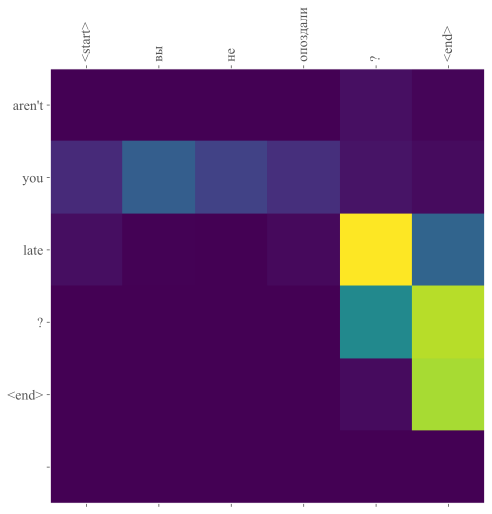

Input: <start> приведите вашу жену <end>
Predicted translation: bring your wife . <end> 


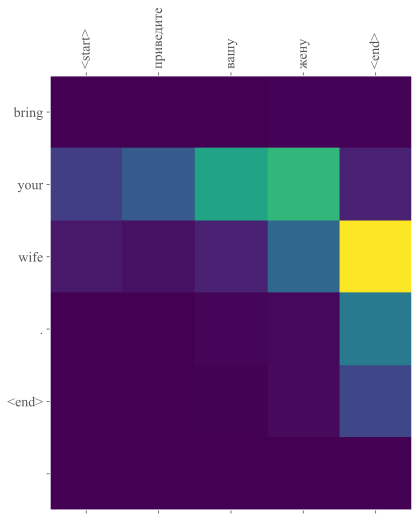

Input: <start> позвоните мне в половине третьего <end>
Predicted translation: call me at . <end> 


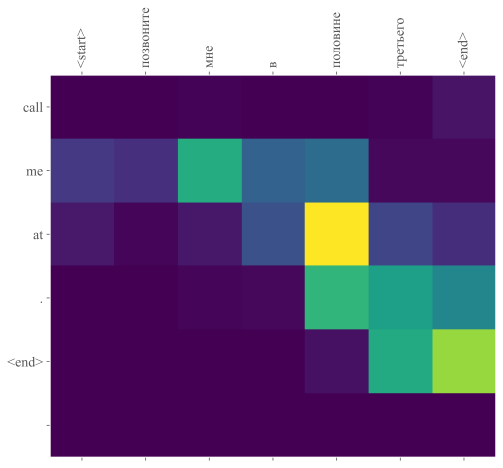

Input: <start> я рассчитываю на вашу помощь <end>
Predicted translation: i count on your help . <end> 


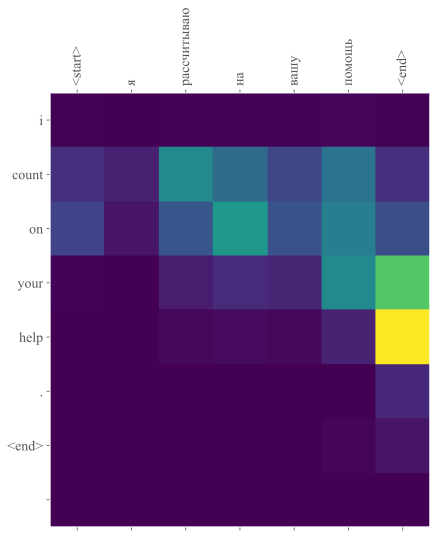

In [37]:
for text in test_text_list:
    translate(text)